In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error


df = pd.read_csv('data/all_v2.csv')
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


# Preprocess data

In [2]:
df = df.query('price > 100000')
df = df.query('price < 500000000')
df = df.query('rooms != -2')
df.index = np.arange(df.shape[0])

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by='date')
df['year'] = df['date'].dt.year
del df['date'], df['time']


categoricals = ['building_type', 'object_type', 'region', 'year']

In [3]:
def calc_mean_room_area(df):
    return (df['area'] - df['kitchen_area']) / (abs(df['rooms']))

In [4]:
df['mean_room_area'] = calc_mean_room_area(df)
df['percent_of_kitchen_area'] = df['kitchen_area'] / df['area']
df['percent_of_level'] = df['level'] / df['levels']

In [5]:
for col in categoricals:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [6]:
# данные отсортированы по времени
# для отложенной выборки возьмём 100000 последних примеров
df_test = df.iloc[df.index[-100000:]]
df = df.iloc[df.index[:-100000]]

print(f"Test target mean value : {df_test['price'].mean()}")
print(f"Train target mean value : {df['price'].mean()}")

Test target mean value : 6137584.3326
Train target mean value : 4361977.834525038


In [7]:
thr = 5e6
expensive_regions = df.groupby('region')['price'].mean().index[df.groupby('region')['price'].mean() > thr]
df['expensive_region'] = df['region'].apply(lambda x: x in expensive_regions).astype(np.int8)
df_test['expensive_region'] = df_test['region'].apply(lambda x: x in expensive_regions).astype(np.int8)

In [8]:
df_test.index = np.arange(df_test.shape[0])

# LGB

In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score as r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def pred_map(pred_df):
    MAE = mean_absolute_error(pred_df['y_true'], pred_df['y_pred'])
    RMSE = rmse(pred_df['y_true'], pred_df['y_pred'])
    R2 = r2_score(pred_df['y_true'], pred_df['y_pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('y_true', 'y_pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Predicted Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'MAE = {}'.format(str(round(MAE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.7, 'R2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# Train LGB on original target

Training fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[100]	training's l1: 742690	valid_1's l1: 755141
[200]	training's l1: 681249	valid_1's l1: 698714
[300]	training's l1: 651877	valid_1's l1: 673780
[400]	training's l1: 631613	valid_1's l1: 656701
[500]	training's l1: 617066	valid_1's l1: 645128
[600]	training's l1: 605271	valid_1's l1: 635914
[700]	training's l1: 594953	valid_1's l1: 628101
[800]	training's l1: 585744	valid_1's l1: 621147
[900]	training's l1: 578135	valid_1's l1: 615485
[1000]	training's l1: 570827	valid_1's l1: 610249
[1100]	training's l1: 565474	valid_1's l1: 606972
[1200]	training's l1: 559889	valid_1's l1: 603368
[1300]	training's l1: 554187	valid_1's l1: 599490
[1400]	training's l1: 549493	valid_1's l1: 596496
[1500]	training's l1: 544567	valid_1's l1: 593121
[1600]	training's l1: 540121	valid_1's l1: 590255
[1700]	training's l1: 536360	valid_1's l1: 588167
[1800]	training's l1: 532392	valid_1's l1: 585622
[1900]	training's l1: 528710	valid_1's l1: 58340

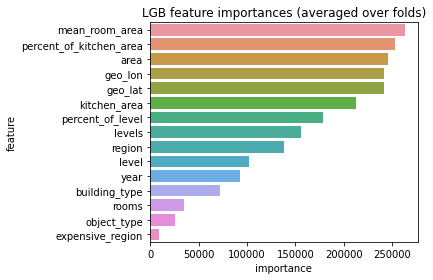

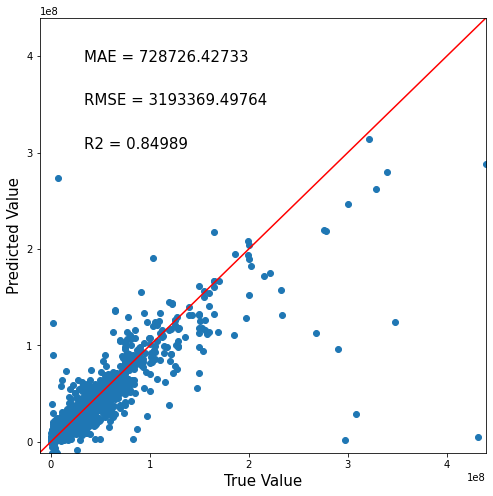

In [10]:
seed = 42
params = {'bagging_fraction': 0.9615087447098526, 
 'bagging_freq': 0, 
 'boosting_type': 'gbdt', 
 'colsample_bytree': None, 
 'feature_fraction': 0.8456892704201968, 
 'lambda_l1': 0.24842029273784616, 
 'lambda_l2': 0.10134215415038501, 
 'learning_rate': 0.08006161308805573, 
 'metric': 'mae', 
 'min_child_samples': None, 
 'min_child_weight': 0.007497551098352097, 
 'min_data_in_leaf': 150, 
 'min_sum_hessian_in_leaf': None, 
 'num_leaves': 152,
 'objective': 'regression', 
 'seed': 42, 
 'subsample_for_bin': 3500, 
 'verbose': -1, 
 'n_estimators': 15000}


def train_lgb(x_data,
              y_data,
              params,
              n_folds = 5):
    
    feature_importance_df = pd.DataFrame()
    models = []
    # Create out of folds array
    oof_predictions = np.zeros(x_data.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = n_folds, random_state = 42, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x_data)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x_data.iloc[trn_ind], x_data.iloc[val_ind]
        y_train, y_val = y_data[trn_ind], y_data[val_ind]

        train_dataset = lgb.Dataset(x_train, y_train, categorical_feature=categoricals + ['expensive_region'])
        val_dataset = lgb.Dataset(x_val, y_val, categorical_feature=categoricals + ['expensive_region'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 20000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 100)
        models.append(model)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = x_train.columns
        fold_importance_df["importance"] = model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        
    mae_score = mean_absolute_error(y_data, oof_predictions)
    print(f'Our out of folds MAE is {mae_score}')
    rmse_score = rmse(y_data, oof_predictions)
    print(f'Our out of folds RMSE is {rmse_score}')
    r2 = r2_score(y_data, oof_predictions)
    print(f'Our out of folds R2 is {r2}')
    
    # Importances
    sns.barplot(x="importance", y="feature", data=feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index())
    plt.title('LGB feature importances (averaged over folds)')
    plt.tight_layout()
    plt.savefig('lgb_importances.png')
    
    return models


# Traing and evaluate
models = train_lgb(df.drop(['price'], 1), df['price'].values, params)

preds = []
for model in models:
    preds.append(model.predict(df_test.drop(['price'], 1)))
preds = np.mean(preds,axis=0)


df_prediction = pd.concat([df_test['price'], pd.Series(preds).astype(int)], axis=1)
df_prediction.columns = ['y_true', 'y_pred']
pred_map(df_prediction)

В качестве итоговой модели был выбран LightGBM c параметрами, подобранными с помощью hyperopt.

### Были введены дополнительные признаки: 
- средняя площадь комнат, 
- доля плозали кухни, 
- высота этажа, 
- дороговизна региона. 

Рассмотренная модель дала хороший прирост в качестве предсказаний. Качество оценивалось на кросс-валидации по 5 фолдам. Средняя абсолютная ошибка стала ниже более, чем на 50% по сравнению с baseline моделью. 

Был проведен анализ важности признаков. На графике видно, что практически все производные признаки имеют преобладающий эффект в работе модели.

Выделять сильные и слабые сегменты в работе модели на данном этапе сложно, посколько в целом предсказания разработанного на ее демо-сервиса выявили проблемы. Основная причина, мы считаем, в недостаточности признаков, характеризующих регионы.  